# Modeling


Oveviews of Models:
 
- Model to predict whether a host is a super host status
- Model to predict either price, number of bookings or occupancy rate

In [59]:
# Imports
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import lightgbm as lgb
from catboost import CatBoostClassifier


In [7]:
# Loading Dataset
df = pd.read_csv("Datasets/AirbnbData/ModelingData.csv")

# Convert Bool columns to int to avoid any errors
df[['oven','stove', 'refrigerator', 'air conditioning', 'tv', 'parking',
    'gym/exercise equipment', 'pool', 'hygiene products', 'laundry',
    'coffee', 'view']] = df[['oven','stove', 'refrigerator', 'air conditioning', 'tv', 'parking',
                            'gym/exercise equipment', 'pool', 'hygiene products', 'laundry',
                            'coffee', 'view']].astype(int)

# Modeling to predict whether a host is a super host

A scenario where this model would be useful is if Airbnb wanted to Re-vamp its superhost assignment methods. Currently this is how Airbnb assigns superhost status:
<blockquote>To be a Superhost, hosts must be the listing owner of a homes listing with an account in good standing and need to have met the following criteria:

Hosted at least 10 reservations, or 3 reservations that total at least 100 nights
Maintained a 90% or higher response rate  
Maintained a less than 1% cancellation rate, with exceptions for cancellations due to Major Disruptive Events or other valid reasons  
Maintained a 4.8 or higher overall rating (A review counts towards Superhost status when either both the guest and the host have submitted a review, or the 14-day window for reviews is over, whichever comes first.)  
Note: The criteria is only evaluated for listings in which the host is the listing owner—any listings in which the host is a co-host won’t contribute towards their Superhost eligibility.</blockquote>

Source: https://airbnb.com/help/article/829

Airbnb may want to modify what factors go into assigning a superhost by looking at other aspects of a listing, but without having much of an effect on the people who currently are superhosts. Another use would be to see which aspects of a host should focus on in order to improve their chance of getting superhost status.  
We would then want to find a model that has a high true positive rate, meaning we correctly classify superhosts as superhosts. We want to focus on a model with higher Recall since the superhost variable is a bit unbalanced. However, we also don't want to compromise the overall accuracy too much as we don't just want to assign the majority of hosts as superhosts, since this would defeat the purpose of having a superhost feature in the first place.

Models to test: 
- Logistic Regression
- XGBoost/Light GBM/CatBoost
- SVM

## Logistic Regression

Looking to train using Stratified K-fold cross validation, start with a model using many variables and later look to build a reduced one that is more interpretable

In [8]:
# Seperate features matrix, dropping some of the uneeded/multicolinear columns

X = df.drop(columns=['id', 'host_id', 'host_since', 'host_is_superhost', 'neighbourhood_cleansed', 'price', 'host_listings_count', "host_total_listings_count"])
y = df["host_is_superhost"]

# Convert object categorical to Dummy encoding

dummy_cols = pd.get_dummies(X[["license", "host_response_time", "neighbourhood_group_cleansed", "room_type"]], drop_first=True, dtype=int)
X = X.drop(["license", "host_response_time", "neighbourhood_group_cleansed", "room_type"], axis=1)
X = pd.concat([X, dummy_cols], axis=1)

X.shape

(42430, 50)

In [ ]:
# Run Stratified K-Fold Cross Validation to deal with class imbalance, use Precision-Recall Curve to find a good threshold
# Use RandomsearchCV to find the best combinations of parameters
# Parallelize where possible when training models & doing searches 
params_logistic = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'C': np.logspace(-2, 2, 10),
    'solver': ['saga', 'lbfgs'], 
    'l1_ratio': np.linspace(0, 1, 5)  
}
logit = LogisticRegression(max_iter=1000, random_state=9, n_jobs=-1)

Skfold = StratifiedKFold(n_splits=5, shuffle=False)

logistic_search = RandomizedSearchCV(estimator=logit, param_distributions=params_logistic, cv=Skfold, scoring='roc_auc', n_jobs=-1, verbose=2, n_iter=50)

logistic_search.fit(X, y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\Afif\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
95 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Afif\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Afif\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Afif\AppData\L

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=LogisticRegression(max_iter=1000, n_jobs=-1,
                                                random_state=9),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02]),
                                        'l1_ratio': array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
                                        'penalty': ['l1', 'l2', 'elasticnet',
                                                    None],
                                        'solver': ['saga', 'lbfgs']},
                   scoring='roc_auc', verbose=2)

In [20]:
print(f"R^2 Score for best estimator: {logistic_search.best_score_}")

R^2 Score for best estimator: 0.8697985701753138


In [11]:
# Fitting Light GBM 

params_gbm = {
    'num_leaves': [10, 15, 20, 25, 30, 40],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
    'n_estimators': [10, 50, 100, 150, 200, 300, 400, 500],
    'subsample': [0.5, 0.7, 1.0],
    'max_depth': [3, 4, 5, 6]
}

gbm = lgb.LGBMClassifier(boosting_type='gbdt', random_state=42, n_jobs=-1)

gbm_search = RandomizedSearchCV(estimator=gbm,
    param_distributions=params_gbm,
    n_iter=50, 
    scoring='roc_auc',
    cv=Skfold,
    verbose=1,
    n_jobs=-1,
    random_state=9
)

gbm_search.fit(X, y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8285, number of negative: 34145
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3136
[LightGBM] [Info] Number of data points in the train set: 42430, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195263 -> initscore=-1.416170
[LightGBM] [Info] Start training from score -1.416170
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=LGBMClassifier(n_jobs=-1, random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.1, 1.0],
                                        'max_depth': [3, 4, 5, 6],
                                        'n_estimators': [10, 50, 100, 150, 200,
                                                         300, 400, 500],
                                        'num_leaves': [10, 15, 20, 25, 30, 40],
                                        'subsample': [0.5, 0.7, 1.0]},
                   random_state=9, scoring='roc_auc', verbose=1)

In [12]:
print(f"R^2 Score for best estimator: {gbm_search.best_score_}")

R^2 Score for best estimator: 0.9248884708642089


In [14]:
# Fitting SVM 
params_svm = {
    'C': np.logspace(-4, 2, 20), 
    'class_weight': [None, 'balanced'],
    'penalty': ["l1", "l2"]
}
svm = LinearSVC(dual=False, random_state=9)

svm_search = RandomizedSearchCV(estimator=svm,
    param_distributions=params_svm,
    n_iter=50, 
    scoring='roc_auc',
    cv=Skfold,
    verbose=1,
    n_jobs=-1,
    random_state=9
)

svm_search.fit(X,y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\Afif\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=LinearSVC(dual=False, random_state=9), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-04, 2.06913808e-04, 4.28133240e-04, 8.85866790e-04,
       1.83298071e-03, 3.79269019e-03, 7.84759970e-03, 1.62377674e-02,
       3.35981829e-02, 6.95192796e-02, 1.43844989e-01, 2.97635144e-01,
       6.15848211e-01, 1.27427499e+00, 2.63665090e+00, 5.45559478e+00,
       1.12883789e+01, 2.33572147e+01, 4.83293024e+01, 1.00000000e+02]),
                                        'class_weight': [None, 'balanced'],
                                        'penalty': ['l1', 'l2']},
                   random_state=9, scoring='roc_auc', verbose=1)

In [17]:
print(f"R^2 Score for best estimator: {svm_search.best_score_}")

R^2 Score for best estimator: 0.8776255157347084


In [29]:
# Catboost 
params_catboost = {
    'iterations': np.arange(100, 1000, 100),
    'learning_rate': np.logspace(-3, 0, 10),
    'depth': np.arange(3, 10),
    'l2_leaf_reg': np.logspace(-3, 2, 10),
    'random_strength': [0.2, 0.5, 0.8],
    'bagging_temperature': np.linspace(0, 1, 10),
    'border_count': np.arange(32, 128, 32),
}

cat = CatBoostClassifier(verbose=0, random_seed=9, thread_count=-1)


cat_search = RandomizedSearchCV(estimator=cat,
    param_distributions=params_catboost,
    n_iter=50, 
    scoring='roc_auc',
    cv=Skfold,
    verbose=1,
    n_jobs=-1,
    random_state=9
)

cat_search.fit(X,y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=<catboost.core.CatBoostClassifier object at 0x00000203BD638A40>,
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bagging_temperature': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                                        'border_count': array([ 32,  64,  96,...
                                        'l2_leaf_reg': array([1.00000000e-03, 3.59381366e-03, 1.29154967e-02, 4.64158883e-02,
       1.66810054e-01, 5.99484250e-01, 2.15443469e+00, 7.74263683e+00,
       2.78255940e+01, 1.00000000e+02]),
                                        'learning_rate': array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
       0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ]),
                                        'random_strength': [0.2, 0.5, 0.8]},
                   random_state=9, scoring='roc_auc', verbose=1)

In [30]:
print(f"R^2 Score for best estimator: {cat_search.best_score_}")

R^2 Score for best estimator: 0.9319012168365362


c:\Users\Afif\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8285, number of negative: 34145
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3136
[LightGBM] [Info] Number of data points in the train set: 42430, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195263 -> initscore=-1.416170
[LightGBM] [Info] Start training from score -1.416170
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

c:\Users\Afif\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


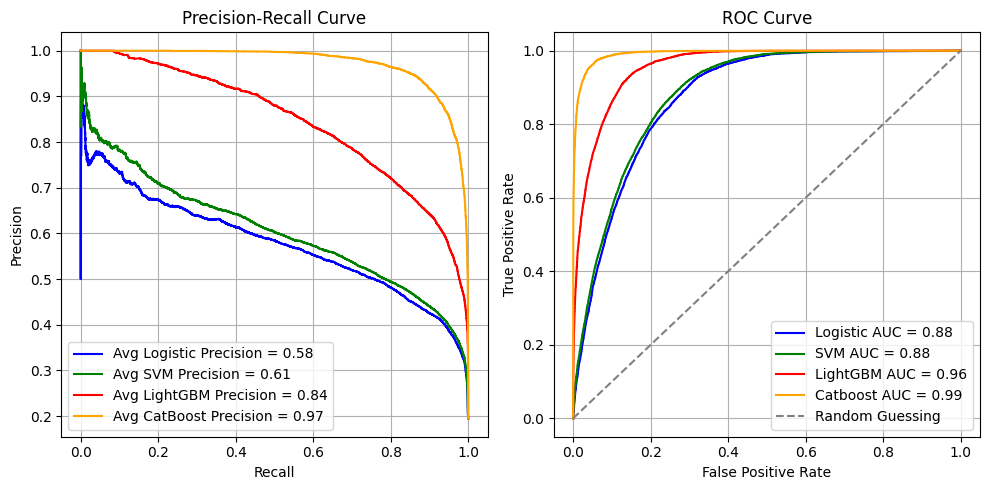

In [ ]:
# Plotting Curves, use precision recall to determine a good threshold

# Best Logistic Model
best_logistic = logistic_search.best_estimator_
best_logistic.fit(X, y)

logistic_proba = best_logistic.predict_proba(X)[:, 1]

logistic_precision, logistic_recall, _ = precision_recall_curve(y, logistic_proba)
avg_logistic_precision = average_precision_score(y, logistic_proba)

logistic_fpr, logistic_tpr, _ = roc_curve(y, logistic_proba)
logistic_roc_auc = roc_auc_score(y, logistic_proba)

# Best LightGBM

best_gbm = gbm_search.best_estimator_
best_gbm.fit(X,y)

gbm_proba = best_gbm.predict_proba(X)[:, 1]

gbm_precision, gbm_recall, _ = precision_recall_curve(y, gbm_proba)
avg_gbm_precision = average_precision_score(y, gbm_proba)

gbm_fpr, gbm_tpr, _ = roc_curve(y, gbm_proba)
gbm_roc_auc = roc_auc_score(y, gbm_proba)

# Best Catboost

best_cat = cat_search.best_estimator_
best_cat.fit(X,y)

cat_proba = best_cat.predict_proba(X)[:, 1]

cat_precision, cat_recall, _ = precision_recall_curve(y, cat_proba)
avg_cat_precision = average_precision_score(y, cat_proba)

cat_fpr, cat_tpr, _ = roc_curve(y, cat_proba)
cat_roc_auc = roc_auc_score(y, cat_proba)

# Best SVM
best_svm = svm_search.best_estimator_
best_svm.fit(X,y)

svm_proba = best_svm.decision_function(X) #best_svm.predict_proba(X)[:, 1]

svm_precision, svm_recall, _ = precision_recall_curve(y, svm_proba)
avg_svm_precision = average_precision_score(y, svm_proba)

svm_fpr, svm_tpr, _ = roc_curve(y, svm_proba)
svm_roc_auc = roc_auc_score(y, svm_proba)

# Plotting Precision-Recall & ROC curvers
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Precision Recall
axes[0].plot(logistic_recall, logistic_precision, label=f'Avg Logistic Precision = {avg_logistic_precision:.2f}', color='b')
axes[0].plot(svm_recall, svm_precision, label=f'Avg SVM Precision = {avg_svm_precision:.2f}', color='g')
axes[0].plot(gbm_recall, gbm_precision, label=f'Avg LightGBM Precision = {avg_gbm_precision:.2f}', color='r')
axes[0].plot(cat_recall, cat_precision, label=f'Avg CatBoost Precision = {avg_cat_precision:.2f}', color='orange')
axes[0].set_title('Precision-Recall Curve')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].legend(loc='best')
axes[0].grid()

# ROC curve
axes[1].plot(logistic_fpr, logistic_tpr, label=f'Logistic AUC = {logistic_roc_auc:.2f}', color='b')
axes[1].plot(svm_fpr, svm_tpr, label=f'SVM AUC = {svm_roc_auc:.2f}', color='g')
axes[1].plot(gbm_fpr, gbm_tpr, label=f'LightGBM AUC = {gbm_roc_auc:.2f}', color='r')
axes[1].plot(cat_fpr, cat_tpr, label=f'Catboost AUC = {cat_roc_auc:.2f}', color='orange')
axes[1].plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Guessing')
axes[1].set_title('ROC Curve')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].legend(loc='best')
axes[1].grid()

plt.tight_layout()

In [43]:
# Catboost performed the best, chose to use it as final model
cat_search.best_params_

{'random_strength': 0.5,
 'learning_rate': 0.046415888336127774,
 'l2_leaf_reg': 0.5994842503189409,
 'iterations': 400,
 'depth': 9,
 'border_count': 128,
 'bagging_temperature': 0.5555555555555556}

In [ ]:
# Setting a threshold & Checking our TPR & FPR
precision, recall, thresholds = precision_recall_curve(y, cat_proba)

valid_thresholds = thresholds[precision[:-1] >= 0.85] 
valid_recalls = recall[:-1][precision[:-1] >= 0.85]

threshold = valid_thresholds[np.argmax(valid_recalls)]

print("Threshold:", threshold)

Threshold: 0.35073036189118273


True Postive Rate (Recall): 0.9531683765841883
False Positive Rate: 0.04079660272367843
Precision: 0.85005382131324


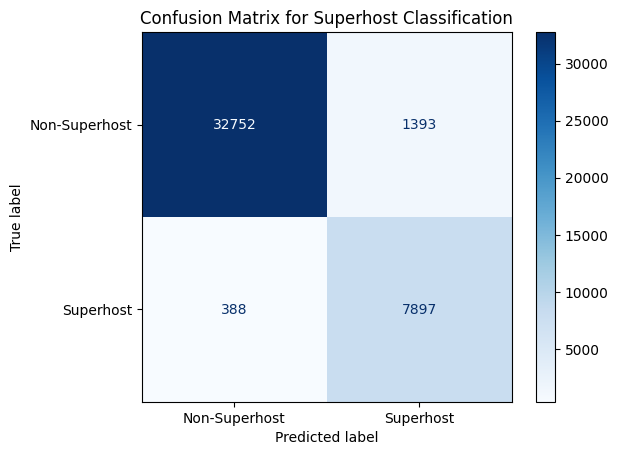

In [ ]:
y_pred = (cat_proba >= threshold).astype(int)

mat = confusion_matrix(y, y_pred)

# Heatmap style confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=mat, 
                              display_labels=["Non-Superhost", "Superhost"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Superhost Classification")

print(f"True Postive Rate (Recall): {mat[1,1] / (mat[1,1] + mat[1,0])}")
print(f"False Positive Rate: {mat[0,1]/ (mat[0,0] + mat[0,1])}")
print(f"Precision: {mat[1,1] / (mat[1,1] + mat[0,1])}")

In [74]:
# Interpretability of Catboost Model
# Find Important Features 

catboost_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': cat_search.best_estimator_.get_feature_importance()
})

catboost_importance_df.sort_values(by='Importance', ascending=False).head(5)

,Feature,Importance
1,host_acceptance_rate,13.090171
14,calculated_host_listings_count_entire_homes,11.941963
15,calculated_host_listings_count_private_rooms,8.605590
0,host_response_rate,8.124121
33,host_about_sentiment_score,6.318699


In [73]:
# Light GBM
lightgbm_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': gbm_search.best_estimator_.feature_importances_
})

lightgbm_importance_df.sort_values(by="Importance", ascending=False).head(10)

,Feature,Importance
14,calculated_host_listings_count_entire_homes,401
12,review_scores_rating,351
1,host_acceptance_rate,349
15,calculated_host_listings_count_private_rooms,322
17,num_amenities,230
0,host_response_rate,189
35,bookings_per_year,173
33,host_about_sentiment_score,167
11,number_of_reviews,153
37,log_price,118
